In [1]:
try:
  %tensorflow_version 2.x
except:
  print("TensorFlow cannot be loaded.")

TensorFlow 2.x selected.


In [2]:
%%time
from __future__ import absolute_import, print_function, division, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install -q -U tensorflow_hub

import tensorflow_hub as hub
from tensorflow.keras import layers

CPU times: user 1.76 s, sys: 330 ms, total: 2.09 s
Wall time: 10.8 s


### Transfer Learning Simple Demo

In [3]:
classifier_url = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"

IMG_SHAPE = (224, 224)

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 0us/step


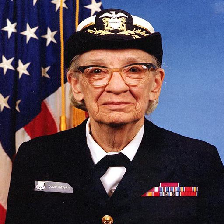

In [4]:
import numpy as np
from PIL import Image

grace_hopper = tf.keras.utils.get_file("image.jpg","https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
print(predicted_class)

458


In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


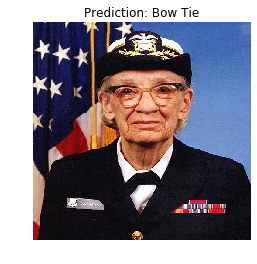

In [9]:
plt.imshow(grace_hopper)
plt.axis("off")
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### Simple Transfer Learning

In [10]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root, 
                                                 target_size=IMAGE_SHAPE,
                                                 batch_size=64,
                                                 )

Found 3670 images belonging to 5 classes.


In [12]:
type(image_data)

keras_preprocessing.image.directory_iterator.DirectoryIterator

In [13]:
image_batch, label_batch = next(image_data)
image_batch.shape
label_batch.shape

(64, 5)

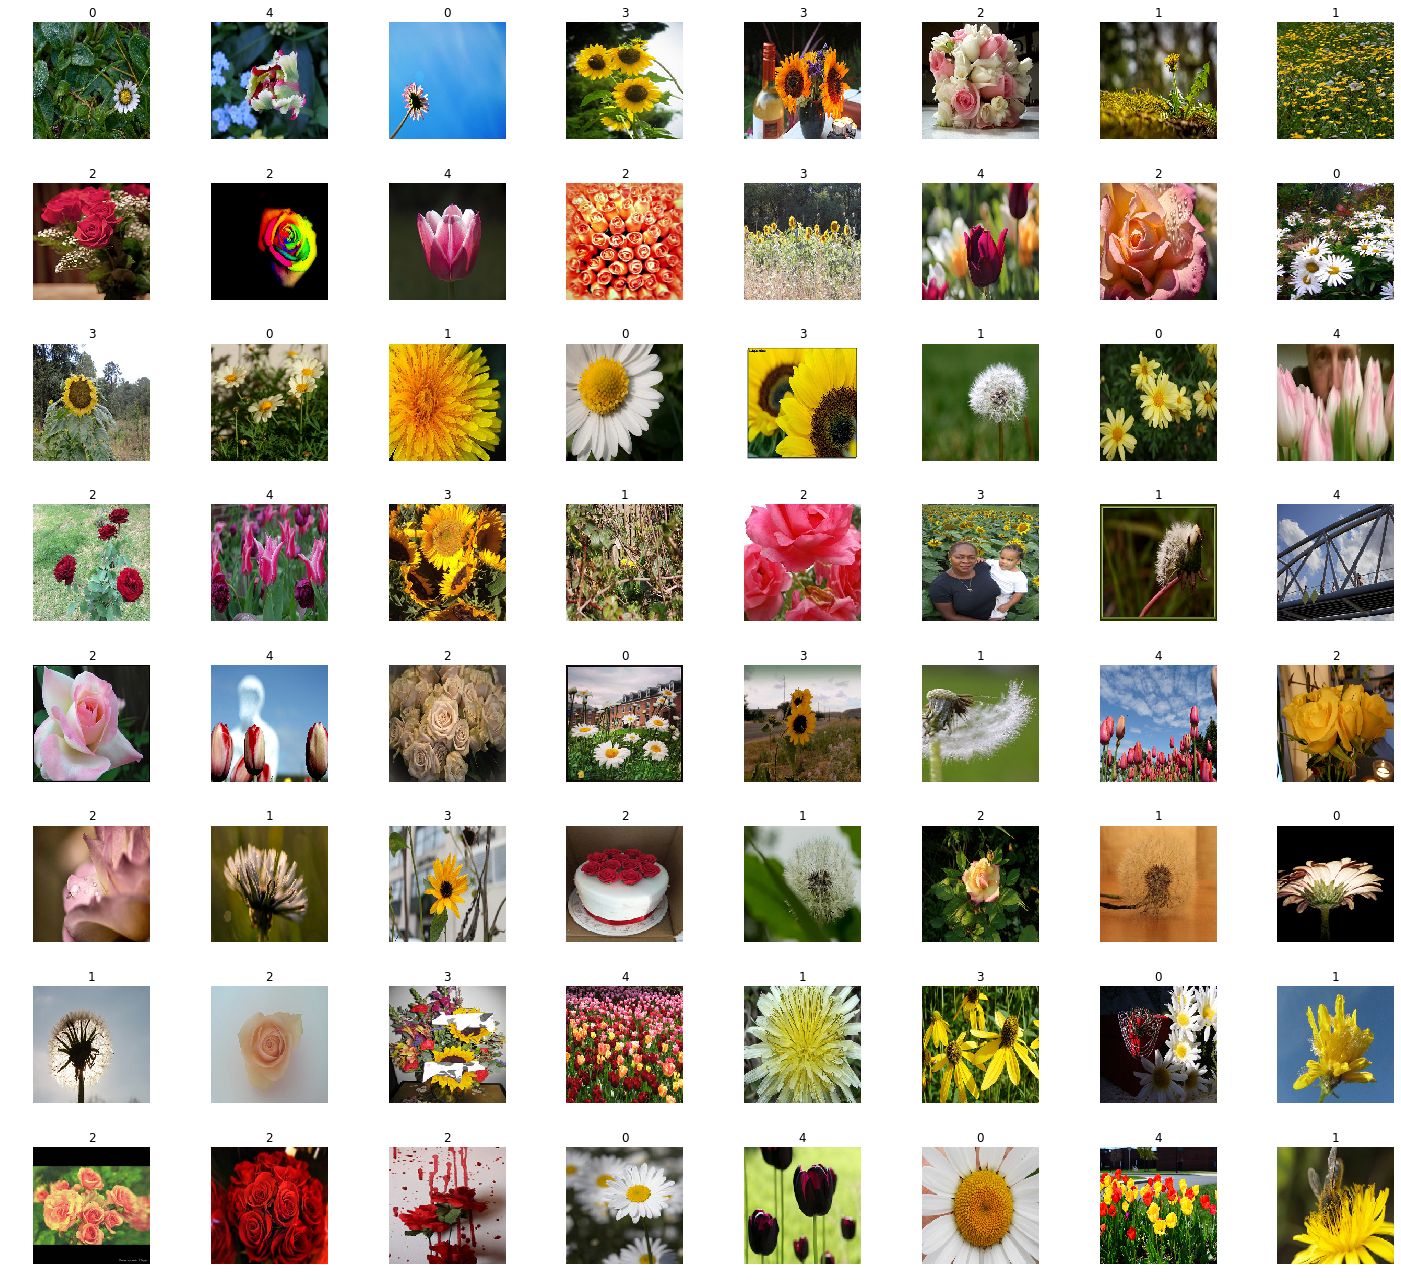

In [14]:
plt.figure(figsize=(20,18))
for i in range(len(image_batch)):
  plt.subplot(8,8,i+1)
  plt.imshow(image_batch[i,:,:,:], interpolation="nearest")
  plt.grid(True)
  plt.axis("off")
  plt.title(np.argmax(label_batch[i]))

plt.tight_layout()

In [0]:
result_batch = classifier.predict(image_batch)

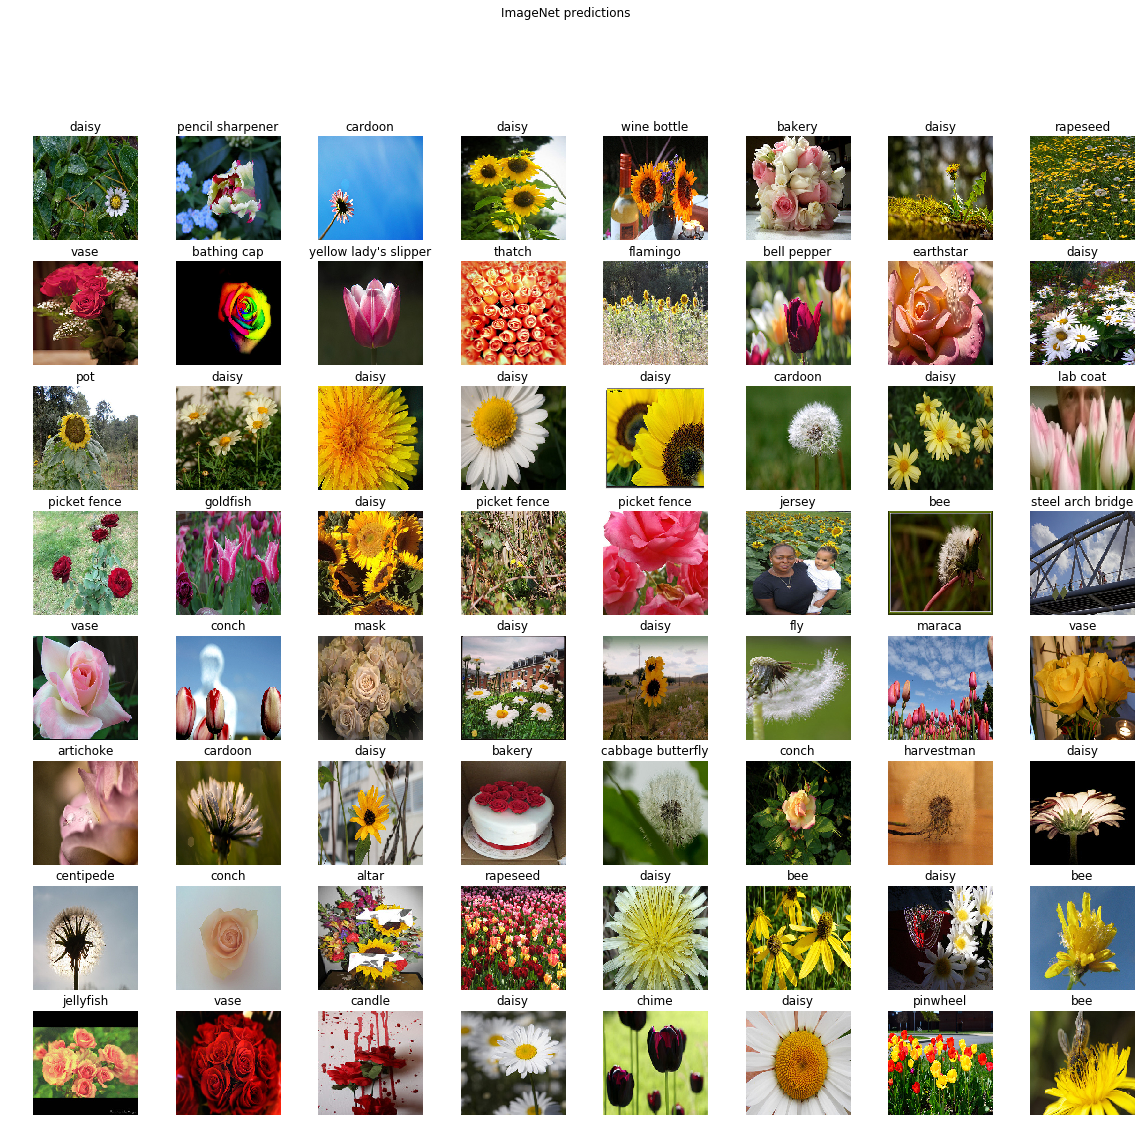

In [16]:
plt.figure(figsize=(20,18))
for i in range(len(image_batch)):
  plt.subplot(8,8,i+1)
  plt.imshow(image_batch[i,:,:,:], interpolation="nearest")
  plt.grid(True)
  plt.axis("off")
  plt.title(imagenet_labels[np.argmax(result_batch[i], axis=-1)])
_ = plt.suptitle("ImageNet predictions")

In [17]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

feature_batch = feature_extractor_layer(image_batch)

print(feature_batch.shape)

(64, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [19]:
model = tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(2048,activation=tf.nn.relu, kernel_initializer="he_uniform"),
                             layers.BatchNormalization(),
                             layers.Dropout(0.4),
                             layers.Dense(1024,activation=tf.nn.relu, kernel_initializer="he_uniform"),
                             layers.BatchNormalization(),
                             layers.Dropout(0.4),
                             layers.Dense(512,activation=tf.nn.relu, kernel_initializer="he_uniform"),
                             layers.BatchNormalization(),
                             layers.Dropout(0.5),
                             layers.Dense(image_data.num_classes, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2048)              2623488   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

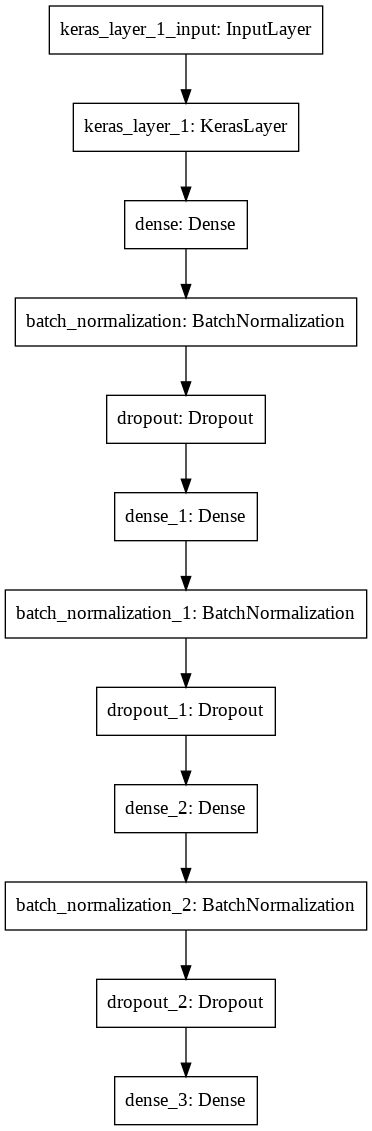

In [20]:
tf.keras.utils.plot_model(model)

In [0]:
predictions = model(image_batch)

In [22]:
predictions.shape

TensorShape([64, 5])

In [0]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["acc"]    
)

In [0]:
# from IPython.display import display, clear_output
# class PlotLearning(tf.keras.callbacks.Callback):
#   def on_train_begin(self, logs={}):
#     self.i = 0
#     self.x = []
#     self.loss = []
#     self.val_loss = []
#     self.acc = []
#     self.val_acc = []
#     self.fig = plt.figure()
#     self.logs = []
#   def on_train_end(self,epoch,logs={}):
#     self.logs.append(logs)
#     self.x.append(self.i)
#     self.loss.append(logs.get('loss'))
#     self.acc.append(logs.get('acc'))
#     self.val_loss.append(logs.get('val_loss'))
#     self.val_acc.append(logs.get('val_acc'))
#     self.i += 1
#     f, ax = plt.subplots(1,2,gigsize=(20,14),sharex=True)
#     ax = ax.flatten()
#     clear_output(wait=True)
#     ax[0].plot(self.x, self.loss, label="Cross Entropy Loss", lw=2)
#     ax[0].plot(self.x, self.val_loss, label="Validation Cross Entropy Loss",lw=2,marker='--')
#     ax[0].legend()
#     ax[0].grid(True)
#     ax[1].plot(self.x, self.acc, label="Accuracy", lw=2)
#     ax[1].plot(self.x, self.val_acc, label="Validation Accuracy",lw=2,marker='--')
#     ax[1].legend()
#     ax[1].grid(True)
#     plt.show()

In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.3,patience=3,verbose=1,mode="auto",min_lr=0.000001)
checkpoint = tf.keras.callbacks.ModelCheckpoint("transfer.h5",monitor="loss",verbose=1,save_best_only=True,mode="auto")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5,mode="auto")
# plotLoss = PlotLearning()

In [27]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history =  model.fit_generator(image_data,
                                  steps_per_epoch=image_data.samples//image_data.batch_size,
                                  epochs=5,
                                  callbacks=[batch_stats_callback])

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


57/57 [==============================] - 45s 797ms/step - loss: 0.3279 - acc: 0.9062
Epoch 3/5
57/57 [==============================] - 46s 799ms/step - loss: 0.2276 - acc: 0.8906
Epoch 4/5
57/57 [==============================] - 46s 803ms/step - loss: 0.1888 - acc: 0.9688
Epoch 5/5
57/57 [==============================] - 45s 797ms/step - loss: 0.1346 - acc: 0.9531


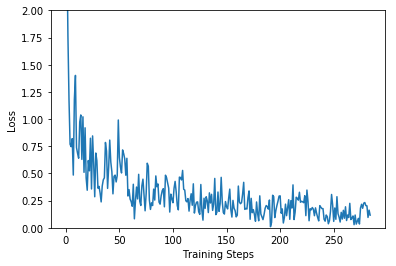

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

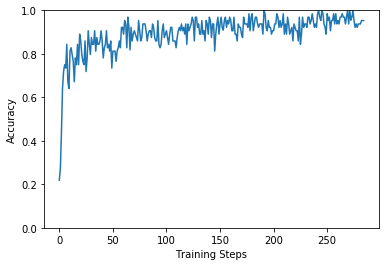

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch,axis=-1)

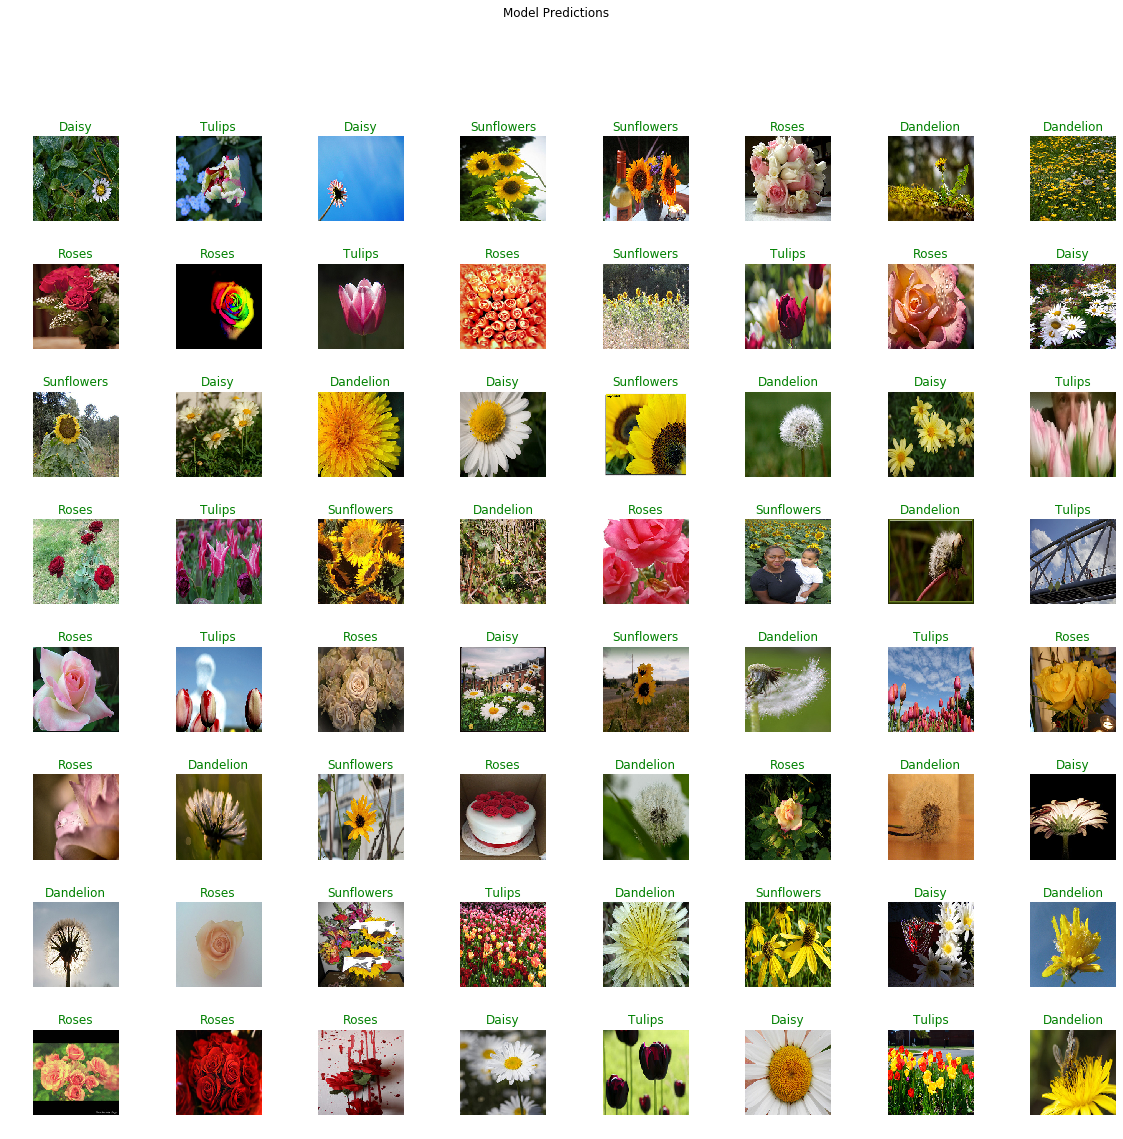

In [33]:
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.5)
for n in range(len(label_batch)):
  plt.subplot(8,8,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n]==label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle('Model Predictions')